# Tutorial: `intrinsic` applied to 3x3 patches from CIFAR-10 images

This notebook contains examples of application of geometry and topology methods from `intrinsic` package to a dataset of 3x3 patches obtained from CIFAR-10 images.

The idea of the task is inspired by the paper
> Gunnar Carlsson, Tigran Ishkhanov, Vin de Silva, and Afra Zomorodian: "On the Local Behavior of Spaces of Natural Images", [available here](https://math.uchicago.edu/~shmuel/AAT-readings/Data%20Analysis%20/mumford-carlsson%20et%20al.pdf)

`intrinsic`: https://github.com/katyafilimoshina/intrinsic/

## Import `intrinsic`

In [1]:
!git clone https://github.com/katyafilimoshina/intrinsic.git

Cloning into 'intrinsic'...
remote: Enumerating objects: 96, done.
remote: Counting objects: 100% (96/96), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 96 (delta 43), reused 76 (delta 23), pack-reused 0
Receiving objects: 100% (96/96), 35.09 KiB | 1.85 MiB/s, done.
Resolving deltas: 100% (43/43), done.


In [2]:
import intrinsic

## Installs and imports

In [3]:
# Install required packages
!pip install gudhi ripser giotto-ph pot

# Import necessary libraries
import numpy as np
import torch
from torchvision import datasets, transforms
import torchvision
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import random

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 834.5/834.5 kB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 554.6/554.6 kB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 835.4/835.4 kB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for hopcroftkarp: filename=hopcroftkarp-1.2.5-py2.py3-none-any.whl size=18101 sha256=d089760a56548ee039defe6c66aa3b476c8e4ee84c6055afbca0a384b71656a0
  Stored in directory: /root/.cache/pip/wheels/ef/0f/3b/0f931844eecc34addd90e72d54cd39c08b7066c5f25c00b9a4
Successfully built hopcroftkarp


## Patches dataset

In [4]:
# Load CIFAR-10 dataset
transform = transforms.Compose([transforms.ToTensor()])
cifar10 = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
data_loader = torch.utils.data.DataLoader(cifar10, batch_size=100, shuffle=True)

# Extract 1000 3x3 patches
def extract_patches(images, patch_size=(3, 3), n_patches=1000):
    patches = []
    images = images.permute(0, 2, 3, 1).numpy()  # Convert from (N, C, H, W) to (N, H, W, C)

    num_images = images.shape[0]  # Total number of images in the batch

    while len(patches) < n_patches:
        # Randomly select an image
        img_idx = random.randint(0, num_images - 1)
        img = images[img_idx]
        H, W, C = img.shape

        # Get all possible patch starting coordinates
        possible_coords = [(i, j) for i in range(H - patch_size[0] + 1) for j in range(W - patch_size[1] + 1)]

        # Randomly select a patch coordinate
        i, j = random.choice(possible_coords)
        patch = img[i:i + patch_size[0], j:j + patch_size[1]]

        patches.append(patch)

    return np.array(patches)

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1000, shuffle=True, num_workers=2)
data_iter = iter(trainloader)
images, labels = next(data_iter)

# Extract 1000 3x3 patches
patches = extract_patches(images, n_patches=1000)


def rgb_to_grayscale(rgb_patch):
    """
    Convert an RGB patch to grayscale.

    Parameters:
    rgb_patch (np.ndarray): RGB patch with shape (height, width, 3).

    Returns:
    np.ndarray: Grayscale patch with shape (height, width).
    """
    return np.dot(rgb_patch[..., :3], [0.2989, 0.5870, 0.1140])

# Convert all patches to grayscale
grayscale_patches = np.array([rgb_to_grayscale(patch) for patch in patches])

# Flatten the patches for TDA analysis
patches_flat = grayscale_patches.reshape((grayscale_patches.shape[0], -1))

100%|██████████| 170498071/170498071 [00:01<00:00, 86932943.86it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


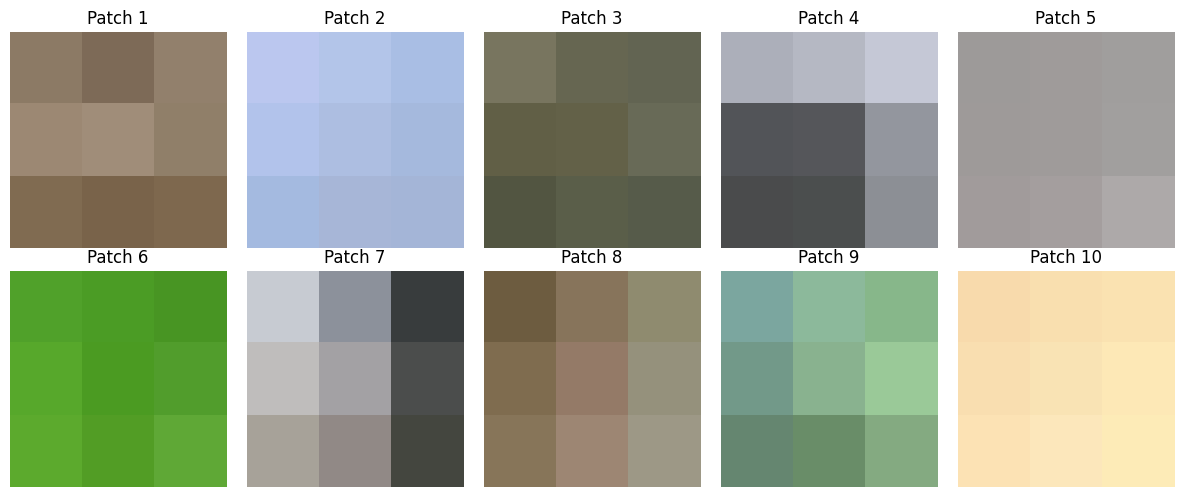

In [5]:
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
axes = axes.flatten()

for i in range(10):
    axes[i].imshow(patches[i])
    axes[i].axis('off')
    axes[i].set_title(f'Patch {i+1}')

plt.tight_layout()
plt.show()

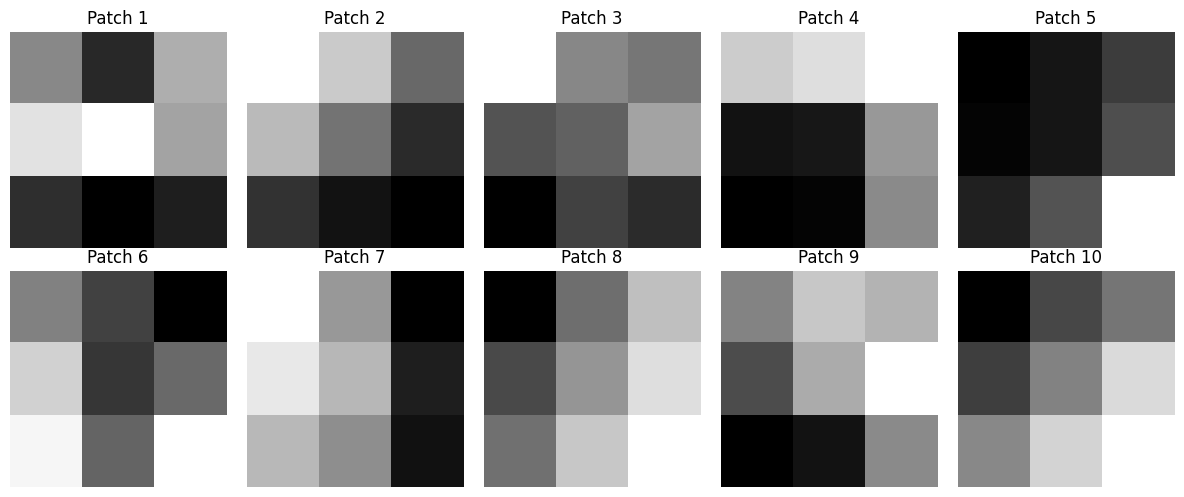

In [6]:
# Plot 10 grayscale patches in a 2x5 grid
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
axes = axes.flatten()

for i in range(10):
    axes[i].imshow(grayscale_patches[i], cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f'Patch {i+1}')

plt.tight_layout()
plt.show()

In [7]:
patches_flat.shape

(1000, 9)

## Peristent homologies

In [11]:
from intrinsic.functional.homology import vr_diagrams, betti, persistence_entropy, total_persistence, amplitude, cross_barcode, r_cross_barcode, mtd, rtd
from intrinsic.utils.tensorboard import draw_heatmap, plot_persistence, plot_persistence_each, plot_betti

In [9]:
# Define the maximum homology dimension to compute
maxdim = 1

# Compute Vietoris-Rips persistence diagram
diag = vr_diagrams(patches_flat, maxdim)

# Compute Betti numbers
betti_numbers = betti(diag)

In [72]:
print("Total number of 0-dimensional holes")
print(diag[0].shape[0])

print("\n[birth, death] intervals of 0-dimensional holes (k=0)")
print(diag[0])

Total number of 0-dimensional holes
998

[birth, death] intervals of 0-dimensional holes (k=0)
[[0.         0.00436823]
 [0.         0.00575589]
 [0.         0.00634289]
 ...
 [0.         0.51316166]
 [0.         0.51418436]
 [0.         0.60920584]]


In [73]:
print("Total number of 1-dimensional holes")
print(diag[1].shape[0])

print("\n[birth, death] intervals of 1-dimensional holes (k=1)")
print(diag[1])

Total number of 1-dimensional holes
300

[birth, death] intervals of 1-dimensional holes (k=1)
[[0.5368438  0.55788547]
 [0.51999176 0.54423285]
 [0.49599087 0.525734  ]
 [0.4755452  0.5033249 ]
 [0.46962905 0.58211845]
 [0.46691534 0.51845497]
 [0.45119873 0.5531414 ]
 [0.4141961  0.4228909 ]
 [0.40365964 0.46230656]
 [0.39699253 0.42878208]
 [0.39203608 0.39576414]
 [0.39119738 0.40251172]
 [0.3904354  0.40124476]
 [0.3798127  0.3817729 ]
 [0.3788006  0.42582512]
 [0.3748506  0.394961  ]
 [0.37275526 0.40347657]
 [0.36848795 0.44483957]
 [0.36533055 0.39820725]
 [0.36400628 0.3822408 ]
 [0.3639702  0.38005787]
 [0.3550994  0.35775846]
 [0.35048765 0.364198  ]
 [0.34635642 0.3807514 ]
 [0.3459279  0.38238725]
 [0.34278038 0.41546687]
 [0.34230056 0.3767847 ]
 [0.33865    0.3727927 ]
 [0.33445096 0.35052058]
 [0.33304545 0.43301645]
 [0.33016095 0.34687784]
 [0.3262748  0.33939633]
 [0.3215118  0.3327071 ]
 [0.3197049  0.33405048]
 [0.3182863  0.32150435]
 [0.31672636 0.3660392 ]
 [0.3

Figure(640x480)


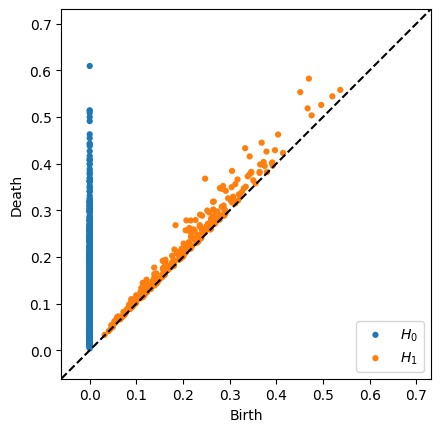

In [75]:
# Plot persistence diagram (H0 -- 0-dimensional holes, H1 -- 1-dimensional holes)

print(plot_persistence(diag))

Figure(640x480)


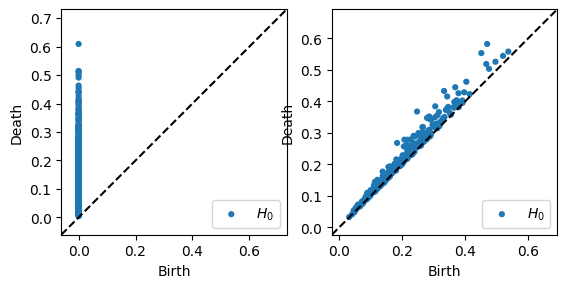

In [76]:
# Plot persistence diagrams separately for different dimensions of holes

print(plot_persistence_each(diag))

Figure(640x480)


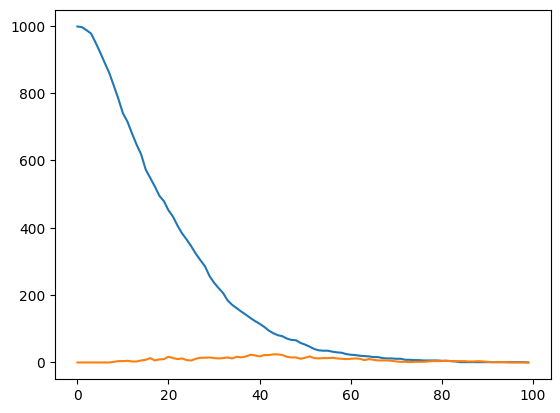

In [81]:
# Plot Betti curves

print(plot_betti(betti_numbers))

In [60]:
# Compute persistence entropy
entropy = persistence_entropy(diag)

print("Sample persistence entropy by dimensions:")
print(entropy)

Sample persistence entropy by dimensions:
[6.7054267 5.4822016]


In [61]:
# Compute total persistence
total_persistence_value = total_persistence(diag, q=1)

print("Sample total persistence:")
print(total_persistence_value)

Sample total persistence:
131.40765


In [65]:
# Compute amplitude
amplitude_value = amplitude(diag, p=1)

print("Sample total persistence amplitude:")
print(amplitude_value)

Sample total persistence amplitude:
92.91924310787088


With `maxdim=2` (0,1,2-dimensional holes):

In [115]:
# Define the maximum homology dimension to compute
maxdim = 2

# Compute Vietoris-Rips persistence diagram
diag = vr_diagrams(patches_flat, maxdim)

In [116]:
print("Total number of 2-dimensional holes")
print(diag[2].shape[0])

print("\n[birth, death] intervals of 2-dimensional holes (k=2)")
print(diag[2])

Total number of 2-dimensional holes
30

[birth, death] intervals of 2-dimensional holes (k=2)
[[0.45406666 0.521712  ]
 [0.44658253 0.46682128]
 [0.44554308 0.47193605]
 [0.4258869  0.43088987]
 [0.4251352  0.42695984]
 [0.41733637 0.42981392]
 [0.384719   0.4050059 ]
 [0.37435502 0.38067818]
 [0.3431561  0.36108157]
 [0.33171687 0.3434421 ]
 [0.32060978 0.3411384 ]
 [0.31483296 0.32012808]
 [0.30923948 0.31377548]
 [0.2965225  0.30386248]
 [0.2923656  0.29560983]
 [0.25709176 0.25846437]
 [0.24646899 0.24928789]
 [0.24369325 0.24928789]
 [0.23745163 0.2479429 ]
 [0.23089156 0.2496158 ]
 [0.21288231 0.21542522]
 [0.21010771 0.21533406]
 [0.17895259 0.18060274]
 [0.17534855 0.18038115]
 [0.16212322 0.16966218]
 [0.12637788 0.14220656]
 [0.12007981 0.12198305]
 [0.0976763  0.0978691 ]
 [0.09663252 0.10362538]
 [0.07566885 0.07930145]]


Figure(640x480)


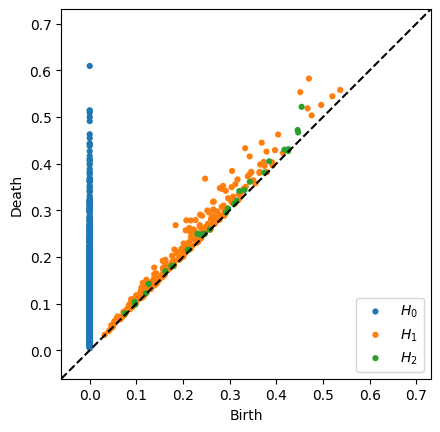

In [117]:
# Plot persistence diagram (H0 -- 0-dimensional holes, H1 -- 1-dimensional holes, H2 -- 2-dimensional holes)

print(plot_persistence(diag))

Compare two persistence diagrams:

In [15]:
# Calculate cross barcode
cross_barcode(patches_flat[:50], patches_flat[50:100])

[array([[0.        , 0.02754692],
        [0.        , 0.0533763 ],
        [0.        , 0.05348929],
        [0.        , 0.05526336],
        [0.        , 0.05644242],
        [0.        , 0.06200393],
        [0.        , 0.06256161],
        [0.        , 0.06329791],
        [0.        , 0.07458024],
        [0.        , 0.07823767],
        [0.        , 0.07980557],
        [0.        , 0.0810131 ],
        [0.        , 0.08110824],
        [0.        , 0.084318  ],
        [0.        , 0.08632328],
        [0.        , 0.08753315],
        [0.        , 0.08931556],
        [0.        , 0.09072672],
        [0.        , 0.09371755],
        [0.        , 0.09715562],
        [0.        , 0.10418525],
        [0.        , 0.10758656],
        [0.        , 0.10785123],
        [0.        , 0.10820525],
        [0.        , 0.1092421 ],
        [0.        , 0.11116652],
        [0.        , 0.11329619],
        [0.        , 0.11348848],
        [0.        , 0.11566239],
        [0.   

In [16]:
# Calculate r cross barcode
r_cross_barcode(patches_flat[:50], patches_flat[50:100])

[array([[ 0., inf]], dtype=float32),
 array([[0.40209717, 0.4260825 ],
        [0.3939118 , 0.39976475],
        [0.38730815, 0.44614866],
        [0.38062003, 0.42459214],
        [0.33792412, 0.37709114],
        [0.33019271, 0.47706833],
        [0.29701248, 0.33876082],
        [0.22402492, 0.2723083 ],
        [0.21831286, 0.4293417 ],
        [0.19955608, 0.22265553],
        [0.19892137, 0.38170582],
        [0.1833293 , 0.23279375],
        [0.1759713 , 0.19012262],
        [0.17532177, 0.37988907],
        [0.17015927, 0.21713331],
        [0.16691375, 0.27226064],
        [0.1668196 , 0.18029177],
        [0.16328008, 0.41300365],
        [0.1572379 , 0.2534078 ],
        [0.15315181, 0.38382998],
        [0.14801027, 0.22743556],
        [0.1439746 , 0.15841134],
        [0.1019889 , 0.18268122],
        [0.09371755, 0.31627452],
        [0.09142885, 0.5633814 ]], dtype=float32)]

In [18]:
# Calculate rtd score
rtd(patches_flat[:50], patches_flat[50:100])

array([0.        , 2.70524965])

In [17]:
# Calculate mtd score
mtd(patches_flat[:50], patches_flat[50:100])

array([17.9485536 ,  0.14349621])

## Magnitude

In [53]:
from intrinsic.functional.magnitude import magnitude

In [59]:
magnitude_value = magnitude(patches_flat[:100])

print("Magnitude of 100 patches:")
print(magnitude_value)

Magnitude of 100 patches:
3.0556038209527183


## Intrinsic dimension

In [32]:
from intrinsic.functional.dimension import mle, mm, pca_sklearn, pca, local_pca, two_nn
from intrinsic.utils.math import mle_aggregate
from intrinsic.utils.tensorboard import plot_dimension

In [34]:
id_mle = mle(patches_flat[:200], k=10)

print("ID (MLE) at each point:")
print(id_mle)

print("\nGlobal ID (MLE):")
print(mle_aggregate(id_mle))

ID (MLE) at each point:
[ 4.7931674   3.59094015  5.37431925  4.11757623  1.78056695 12.64260429
 11.83566617  4.12101196 10.14402181  5.87039685 11.70343161 11.46092951
  2.43678567  1.70015832  1.63843921  9.09343374  6.48431612  1.09284438
  3.65522878  3.99641998  3.66439585  3.23321818 13.87287875  5.90246759
  4.48522649  2.11614456  4.94385371  3.72129783  1.80541179  5.8945577
  1.84048561  7.7865729   2.48533631  4.46135011  3.17704383  3.19543742
  3.242646   14.95825842  2.67097937  1.30553068  2.80232405 13.98461382
  8.51219268  9.61060519  2.75440489  4.8474796   3.01678664  2.43153536
  2.54695915  0.89944352  3.44262259  2.20243064  1.81136563  3.32027562
  1.88556723  5.11985443  4.40853989  3.23634342  6.057483    3.46920615
  1.04245254 11.32029715  1.92274394  3.50985885  7.20295209  8.06315842
  6.5201101   5.42085111  2.24098567  3.08422326  8.96414708  2.18819865
  1.64879069  7.79068401  1.47627631  7.59332711  1.02128397  3.57985757
  2.56605232  7.89886945  2.

In [28]:
id_mm = mm(patches_flat[:200], k=10)

print("ID (MM) at each point:")
print(id_mm)

print("\nGlobal ID (MM):")
print(id_mm.mean())

ID (MM) at each point:
[ 5.12780623  4.31567868  5.6404403   4.3402399   1.72736707 13.91159674
 13.05872774  4.29901199 11.18520831  6.88368336 12.78731352 12.61192096
  2.71418863  2.07047915  1.78329026 10.02993112  6.92366734  1.19037029
  4.23245615  4.47285482  3.83410874  3.3868458  15.14397138  6.75160833
  4.73669694  2.16868298  5.52612112  4.12121671  1.77156326  6.56180044
  2.16847517  8.71621881  2.62278333  4.72649195  3.25700741  3.41600002
  3.63250264 16.6894164   2.80749159  1.31571814  3.26332504 15.77581948
  9.47132331 10.72519174  3.04822082  5.42776764  3.21953979  2.76825908
  2.64157841  0.91651329  3.63826864  2.33667876  1.89351384  3.65086576
  1.9797116   5.35941261  4.74567678  3.500795    6.50417191  3.72601406
  1.1399418  12.62544913  2.05061305  3.91236216  7.97326986  8.70571313
  7.36180403  6.08074929  2.30990048  3.58824648 10.23753644  2.18949749
  1.65243278  8.30205632  1.69870311  8.2889846   1.10632536  3.96793479
  2.56788074  8.64256002  2.

In [27]:
id_pca_sklearn = pca_sklearn(patches_flat[:200], explained_variance=0.95)

print("ID (PCA sklearn):")
print(id_pca_sklearn)

ID (PCA sklearn):
2


In [26]:
id_pca = pca(patches_flat[:200], explained_variance=0.95)

print("ID (PCA):")
print(id_pca)

ID (PCA):
2


In [25]:
id_local_pca = local_pca(patches_flat[:200], k=10, explained_variance=0.95)

print("ID (local PCA) at each point:")
print(id_local_pca)

print("\nMean ID (local PCA):")
print(id_local_pca.mean())

ID (local PCA) at each point:
[4 5 5 5 5 3 4 5 4 5 4 4 5 4 5 4 3 2 5 4 5 5 4 4 4 4 5 5 5 5 4 4 4 4 5 4 5
 5 4 5 5 4 4 4 5 4 5 4 4 2 4 4 5 4 5 3 4 3 4 5 2 4 4 5 3 5 5 5 4 5 4 4 5 4
 4 4 2 5 5 4 2 1 5 4 4 2 5 5 5 4 4 4 5 4 4 4 5 4 4 2 4 4 4 5 4 4 4 4 4 4 4
 4 5 4 4 5 4 4 4 4 4 4 4 4 3 4 5 5 3 4 4 3 4 4 4 4 3 3 5 3 5 4 4 3 4 4 3 3
 4 4 4 4 4 4 4 3 4 4 3 5 4 3 4 3 4 3 3 4 4 4 4 4 3 4 3 3 5 4 3 4 3 3 4 3 4
 4 5 4 4 4 4 4 3 4 5 3 3 4 4 4]

Mean ID (local PCA):
4.015


In [24]:
id_twonn = two_nn(patches_flat[:200])

print("ID (TwoNN):")
print(id_twonn)

ID (TwoNN):
3.975851410450249


<Axes: xlabel='Method', ylabel='ID'>

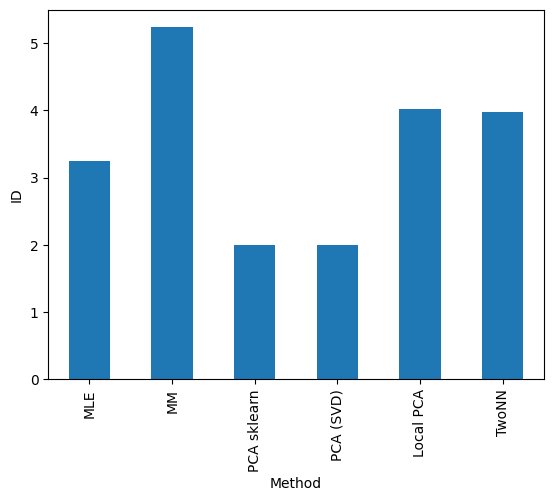

In [114]:
# id_estimates = [mle_aggregate(id_mle), id_mm.mean(), id_pca_sklearn, id_pca, id_local_pca.mean(), id_twonn]
id_estimates = [mle_aggregate(id_mle), id_mm.mean(), id_pca_sklearn, id_pca, id_local_pca.mean(), id_twonn]
columns = ["MLE", "MM", "PCA sklearn", "PCA (SVD)", "Local PCA", "TwoNN"]

plot_dimension(id_estimates, columns)

## Curvature

In [35]:
from intrinsic.utils.math import mle_aggregate
from intrinsic.functional.curvature import density, mean_density, volume, quadratic_fit, curvature

In [40]:
id_mle = mle_aggregate(mle(patches_flat[:300], k=10))

In [42]:
density_est = density(patches_flat[:300], k=10, dim=id_mle)

print("Density estimates at each point:")
print(density_est)

Density estimates at each point:
[0.05495432 0.05281785 0.05252239 0.05316574 0.05608394 0.05285664
 0.040742   0.05367209 0.04024257 0.0532013  0.05055329 0.04983595
 0.05277039 0.05591783 0.0555483  0.0523598  0.05398684 0.05092695
 0.03874712 0.05213237 0.0547573  0.05471002 0.04325222 0.04489666
 0.05104869 0.05401517 0.05312108 0.05159134 0.05542213 0.05305177
 0.0559601  0.0489971  0.05576808 0.05529095 0.0557766  0.05553776
 0.0542247  0.0499645  0.05551924 0.0559754  0.05336455 0.05448387
 0.05351784 0.05189708 0.05315155 0.05588075 0.05355444 0.05505742
 0.0557622  0.04929873 0.05236511 0.05447263 0.05559936 0.05595806
 0.05499987 0.05355063 0.05554031 0.05536427 0.05220392 0.05315629
 0.04228767 0.04907967 0.05533854 0.05260384 0.05174435 0.04805194
 0.05257754 0.05203939 0.05559125 0.05335213 0.05405    0.05470844
 0.05462453 0.05200588 0.0557694  0.05382391 0.04307286 0.04206482
 0.05374611 0.04703919 0.05207553 0.05010751 0.05522672 0.05555685
 0.05485965 0.05052701 0.0444

In [44]:
print("Mean density (mu) array is of shape:")
print(mean_density(patches_flat[:300], k=10, dim=id_mle).shape)

(300, 10)

In [51]:
print("Volume estimate for each point at each radii (k):")
print(volume(patches_flat[:300], k=10, dim=id_mle))

print("\nShape of this array is:")
print(volume(patches_flat[:300], k=10, dim=id_mle).shape)

Volume estimate for each point at each radii (k):
[[ 1.99010031  3.97596438  5.97095003 ... 15.95401454 17.95452666
  19.94387702]
 [ 2.08211464  4.18767249  6.23675932 ... 16.69399755 18.776597
  20.88987804]
 [ 2.03976033  4.11449236  6.14546084 ... 16.46450025 18.49365635
  20.55069184]
 ...
 [ 2.10744253  4.24345068  6.49345102 ... 16.89908597 18.99412694
  21.02964532]
 [ 2.04673235  4.09480502  6.16898919 ... 16.49246942 18.49104163
  20.52061429]
 [ 1.98729557  3.97353253  5.96829161 ... 15.94131716 17.92355722
  19.91874123]]

Shape of this array is:
(300, 10)


In [48]:
print("Quadratic fit values (\widehat{C}) for each point:")
print(quadratic_fit(patches_flat[:300], k=10, dim=id_mle))

Quadratic fit values (\widehat{C}) for each point:
[3.73760499e+04 5.52737934e+03 3.24372929e+03 5.20061692e+03
 6.42040602e+05 4.34876085e+03 6.43838039e+01 7.39222881e+03
 5.35322382e+01 6.50577502e+03 1.19809931e+03 9.16881582e+02
 5.54552912e+03 5.27595651e+05 1.60377742e+05 3.05057981e+03
 1.12985365e+04 2.19213230e+03 6.55653501e+01 3.14826984e+03
 2.54247573e+04 2.71637030e+04 1.22339720e+02 2.19681526e+02
 1.43441003e+03 1.16689915e+04 5.32836043e+03 2.25473129e+03
 8.41452450e+04 5.28020144e+03 4.91353162e+05 6.30809471e+02
 2.21245814e+05 6.44624759e+04 1.97217346e+05 1.29011100e+05
 1.70700100e+04 8.97003245e+02 1.15850594e+05 4.73453498e+05
 9.08584091e+03 2.01355779e+04 7.88716587e+03 2.24018328e+03
 6.67077673e+03 3.38962875e+05 8.17029531e+03 6.45770208e+04
 2.28928189e+05 8.73845552e+02 3.24896754e+03 2.30579599e+04
 1.64901506e+05 4.80682696e+05 5.21195824e+04 6.78922382e+03
 1.17796967e+05 7.97548117e+04 2.67642158e+03 5.41304290e+03
 1.43584005e+02 5.92439213e+02 8.2

In [52]:
print("Curvature estimation:")
print(curvature(patches_flat[:300], k=10, dim=id_mle))

Curvature estimation:
[-1.17833253e+06 -1.74258406e+05 -1.02263127e+05 -1.63956761e+05
 -2.02412328e+07 -1.37100801e+05 -2.02978996e+03 -2.33050408e+05
 -1.68767909e+03 -2.05103706e+05 -3.77717655e+04 -2.89059812e+04
 -1.74830604e+05 -1.66331948e+07 -5.05613384e+06 -9.61738183e+04
 -3.56202251e+05 -6.91100532e+04 -2.06703986e+03 -9.92536338e+04
 -8.01551226e+05 -8.56373935e+05 -3.85693172e+03 -6.92576902e+03
 -4.52217932e+04 -3.67881366e+05 -1.67984055e+05 -7.10835745e+04
 -2.65279718e+06 -1.66465775e+05 -1.54905994e+07 -1.98871556e+04
 -6.97508542e+06 -2.03227020e+06 -6.21755415e+06 -4.06725636e+06
 -5.38156070e+05 -2.82792887e+04 -3.65235288e+06 -1.49262873e+07
 -2.86443911e+05 -6.34802407e+05 -2.48653995e+05 -7.06249282e+04
 -2.10305617e+05 -1.06862813e+07 -2.57580049e+05 -2.03588139e+06
 -7.21728309e+06 -2.75492099e+04 -1.02428271e+05 -7.26934611e+05
 -5.19875185e+06 -1.51541979e+07 -1.64314313e+06 -2.14039828e+05
 -3.71371503e+06 -2.51438259e+06 -8.43779540e+04 -1.70653789e+05
 -4